## **Mengimpor libaries**

In [6]:
# Mengimpor libaries pandas,numpy dan json untuk memproses data dalam format JSON
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## **Install mysql connector**

In [7]:
# install mysql connector
!pip install mysql-connector-python

In [8]:
# import libraries
import mysql.connector
from mysql.connector import Error

In [9]:
# Define MySQL details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = '3306'
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [10]:
# function to fetch data from database, the connection is closed after use.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        # use with to ensure the connection is closed after use
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params) # read the query to dataframe format
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

In [11]:
query = """

WITH order_garden_data AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        act.updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')) AS old_updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) 
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
        
),
build_start_attributes_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'acc_gardener'
        END AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')) AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start'
        END AS attributes_status,
        dt.created_at AS attributes_created_at,
        dt.updated_at AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            dt.created_at,
            dt.updated_at
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        (
            subject_type LIKE '%OrderDesign%' 
            OR subject_type LIKE '%OrderGarden%'
            OR subject_type LIKE '%OrderGardenCareDetail%'
        )
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
),
build_start_old_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        dt.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start' 
        END AS old_status,
        dt.created_at AS old_created_at,
        dt.datetime AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'in_review'
        END AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at'))
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            dt.created_at,
            dt.datetime
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
    (
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
    )
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
)
SELECT * FROM (
SELECT * FROM order_garden_data
UNION ALL
SELECT * FROM build_start_attributes_status
UNION ALL
SELECT * FROM build_start_old_status) AS combined_data
ORDER BY id DESC;

"""
interval_orders = fetch_data(host, port, user, passwd, databs, query)

## **Explore Data**
Dalam proyek ini, kami menggunakan tabel **activity_log** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. OrderDesign
2. OrderGarden
3. OrderGardenCareDetail

In [12]:
# Menampilkan 5 baris pertama data.
interval_orders.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
4,16475,App\Models\OrderGardenCare,291,"{""attributes"":{""id"":291,""id_user"":1207,""id_gar...",2024-11-14 21:00:23,2024-11-14 21:00:23,on_going,2024-11-13T03:48:28.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:28.000000Z,2024-11-14T14:00:23.000000Z,34.1986,NaN,7.3989


In [13]:
# Memfilter data berdasarkan subject_type
proses_subject_type = interval_orders[interval_orders['subject_type'].isin(['App\Models\OrderDesign','App\Models\OrderGarden','App\Models\OrderGardenCareDetail'])]

Dalam proyek ini, kami menggunakan hasil join tabel **activity_log** dan tabel **datetime** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. **OrderDesign**
2. **OrderGarden**
3. **OrderGardenCareDetail**

In [14]:
# Mengambil nilai unik dari kolom `subject_type`
proses_subject_type['subject_type'].unique()

array(['App\\Models\\OrderDesign', 'App\\Models\\OrderGardenCareDetail',
       'App\\Models\\OrderGarden'], dtype=object)

In [15]:
proses_subject_type.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
5,16474,App\Models\OrderGardenCareDetail,1480,"{""attributes"":{""id"":1480,""id_order_garden_care...",2024-11-14 21:00:23,2024-11-14 21:00:23,acc_gardener,2024-11-13T03:48:29.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:29.000000Z,2024-11-14T14:00:23.000000Z,34.1983,NaN,7.3989


In [16]:
proses_subject_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1434 entries, 0 to 1542
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1434 non-null   int64         
 1   subject_type           1434 non-null   object        
 2   subject_id             1434 non-null   int64         
 3   properties             1434 non-null   object        
 4   created_at             1384 non-null   datetime64[ns]
 5   updated_at             1334 non-null   datetime64[ns]
 6   old_status             1148 non-null   object        
 7   old_created_at         1098 non-null   object        
 8   old_updated_at         1098 non-null   object        
 9   attributes_status      1415 non-null   object        
 10  attributes_created_at  1365 non-null   object        
 11  attributes_updated_at  1365 non-null   object        
 12  order_cycle_time       1365 non-null   float64       
 13  id_datet

Berdasarkan hasil yang ditampilkan di atas, terdapat beberapa kolom seperti 
- **old_created_at**  
- **old_updated_at**  
- **attributes_created_at**  
- **attributes_updated_at**   
yang saat ini memiliki tipe data **object**.  

Tipe data ini belum sesuai dengan konteks data tersebut yang seharusnya berada dalam format **datetime**.Hal ini akan menjadi perhatian pada **tahap transformasi data**,   
di mana tipe data pada kolom-kolom tersebut akan diubah menjadi **datetime** agar lebih sesuai untuk analisis dan manipulasi data lebih lanjut.

In [17]:
# Filter baris pada dataframe proses_subject_type yang memiliki perubahan status
# (yaitu atribut 'attributes_status' tidak sama dengan 'old_status')
proses_subject_type = proses_subject_type[proses_subject_type['attributes_status'] != proses_subject_type['old_status']]

In [18]:
# Hapus baris duplikat pada dataframe proses_subject_type berdasarkan kolom 'subject_id', 'old_status', dan 'attributes_status'
# Jaga hanya baris pertama dari setiap grup duplikat
proses_subject_type = proses_subject_type.drop_duplicates(subset=['subject_id','old_status','attributes_status'], keep='first')

## **Data Transformation**

##### Pada tahap ini, kami melakukan serangkaian transformasi data yang bertujuan untuk mempersiapkan dataset agar lebih siap untuk analisis mendalam.  
##### Transformasi ini mencakup dua aspek utama: pembuatan kolom baru dan pengubahan tipe data.

In [19]:
proses_subject_type.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
5,16474,App\Models\OrderGardenCareDetail,1480,"{""attributes"":{""id"":1480,""id_order_garden_care...",2024-11-14 21:00:23,2024-11-14 21:00:23,acc_gardener,2024-11-13T03:48:29.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:29.000000Z,2024-11-14T14:00:23.000000Z,34.1983,NaN,7.3989


In [20]:
# Menampilkan tipe data dari setiap kolom dalam DataFrame 'order_cycletime'
proses_subject_type.dtypes

id                                int64
subject_type                     object
subject_id                        int64
properties                       object
created_at               datetime64[ns]
updated_at               datetime64[ns]
old_status                       object
old_created_at                   object
old_updated_at                   object
attributes_status                object
attributes_created_at            object
attributes_updated_at            object
order_cycle_time                float64
id_datetime                     float64
time_interval_status            float64
dtype: object

In [21]:
# Mengonversi kolom 'old_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['old_created_at'] = pd.to_datetime(proses_subject_type['old_created_at'], errors='coerce')
proses_subject_type['old_created_at'] = pd.to_datetime(proses_subject_type['old_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'old_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['old_updated_at'] = pd.to_datetime(proses_subject_type['old_updated_at'], errors='coerce')
proses_subject_type['old_updated_at'] = pd.to_datetime(proses_subject_type['old_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['attributes_created_at'] = pd.to_datetime(proses_subject_type['attributes_created_at'], errors='coerce')
proses_subject_type['attributes_created_at'] = pd.to_datetime(proses_subject_type['attributes_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['attributes_updated_at'] = pd.to_datetime(proses_subject_type['attributes_updated_at'], errors='coerce')
proses_subject_type['attributes_updated_at'] = pd.to_datetime(proses_subject_type['attributes_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

In [22]:
# Menampilkan tipe data dari setiap kolom dalam DataFrame 'order_cycletime'
proses_subject_type.dtypes

id                                int64
subject_type                     object
subject_id                        int64
properties                       object
created_at               datetime64[ns]
updated_at               datetime64[ns]
old_status                       object
old_created_at           datetime64[ns]
old_updated_at           datetime64[ns]
attributes_status                object
attributes_created_at    datetime64[ns]
attributes_updated_at    datetime64[ns]
order_cycle_time                float64
id_datetime                     float64
time_interval_status            float64
dtype: object

##### Setelah dilakukan proses transformasi data, tipe data pada kolom `old_created_at`, `old_updated_at`, `attributes_created_at`, dan `attributes_updated_at` telah berhasil diubah dari tipe object menjadi tipe datetime. Perubahan ini memastikan bahwa data pada kolom-kolom tersebut lebih sesuai dengan konteksnya, yaitu merepresentasikan nilai waktu dan tanggal.

In [23]:
proses_subject_type.shape

(861, 15)

## **Analysis and Visualization**
Tahap "Analysis and Visualization" (Analisis dan Visualisasi) adalah langkah krusial dalam proses eksplorasi data. Dalam konteks ini, kita berfokus pada dua aspek utama: ringkasan **statistik (summary statistics)** dan **visualisasi data**

In [24]:
# Ringkasan statistik Type Data Numerik.
proses_subject_type.describe()

,id,subject_id,created_at,updated_at,old_created_at,old_updated_at,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
count,861.000000,861.000000,811,761,540,540,780,780,792.000000,262.000000,552.000000
mean,7516.763066,956.945412,2024-11-03 20:48:40.780517888,2024-11-03 17:12:42.189224704,2024-10-06 10:32:53.529629696,2024-10-26 03:50:07.751851776,2024-10-15 10:08:19.946153728,2024-11-03 18:47:56.365384704,457.720041,79.393130,204.383777
min,3.000000,19.000000,2024-08-25 18:29:15,2024-08-25 18:29:15,2024-06-28 02:45:41,2024-07-02 03:21:37,2024-06-28 02:45:41,2024-10-21 09:00:39,0.000000,8.000000,3.510000
25%,2174.000000,816.000000,2024-10-28 12:29:05,2024-10-28 15:32:38,2024-09-22 15:01:09.750000128,2024-10-24 08:32:43,2024-10-11 03:12:41,2024-10-28 09:47:13,0.000000,58.250000,7.258150
50%,4331.000000,988.000000,2024-11-04 06:50:59,2024-11-04 07:07:38,2024-10-21 09:00:39,2024-11-01 03:21:01.500000,2024-10-28 00:37:28,2024-11-03 23:50:55,27.095300,75.500000,27.857500
75%,13941.000000,1340.000000,2024-11-10 17:30:10,2024-11-10 17:30:10,2024-11-01 13:20:59,2024-11-06 10:28:05,2024-11-05 05:28:44,2024-11-10 10:30:10,560.436375,102.000000,134.853075
max,16519.000000,1498.000000,2024-11-15 08:47:27,2024-11-15 08:47:27,2024-11-14 02:32:30,2024-11-14 13:36:27,2024-11-15 01:47:27,2024-11-15 01:47:27,3246.923900,138.000000,3219.215300
std,5892.647478,417.783156,NaN,NaN,NaN,NaN,NaN,NaN,807.073478,29.789717,474.598688


Fokus pada kolom `time_interval_status` memberikan wawasan penting mengenai waktu yang dibutuhkan untuk menyelesaikan siklus pesanan.  
Melalui ringkasan statistik deskriptif, kita dapat memahami karakteristik dasar dari data ini, yang mencakup berbagai metrik kunci.

In [25]:
# Ringkasan statistik Type Data Numerik.
proses_subject_type.describe(include='object')

,subject_type,properties,old_status,attributes_status
count,861,861,602,842
unique,3,737,11,11
top,App\Models\OrderGardenCareDetail,"{""attributes"":{""id"":1313,""id_order_garden_care...",paid,paid
freq,456,3,181,194


#### **Waktu yg dibutuhkan (interval waktu) untuk tiap proses berapa lama ?**

## **Order Design**

In [26]:
interval_orderdesign = proses_subject_type[(proses_subject_type['subject_type'] == 'App\Models\OrderDesign') & (proses_subject_type['attributes_status'].isin(['new', 'paid', 'wait_freelancer', 'on_going', 'in_review_internal', 'in_review', 'finish', 'expired'])) & (proses_subject_type['old_status'].isin(['new', 'paid', 'wait_freelancer', 'on_going', 'in_review_internal', 'in_review', 'finish', 'expired']))]
interval_orderdesign = interval_orderdesign.groupby(['old_status','attributes_status'])['time_interval_status'].mean().sort_values(ascending=True).reset_index()
interval_orderdesign = interval_orderdesign[interval_orderdesign['attributes_status'] != interval_orderdesign['old_status']]
# interval_orderdesign = interval_orderdesign.drop(index=[5, 9]).reset_index(drop=True)
interval_orderdesign['time_interval_status_days'] = interval_orderdesign['time_interval_status'].apply(lambda x: f"{int(x // 24)} Hari")


# Definisikan urutan status yang diinginkan
status_order = ['new', 'paid', 'wait_freelancer', 'on_going', 'in_review_internal', 'in_review', 'finish', 'expired']
interval_orderdesign['old_status'] = pd.Categorical(interval_orderdesign['old_status'], categories=status_order, ordered=True)
interval_orderdesign_sorted = interval_orderdesign.sort_values(by='old_status', ascending=True).reset_index(drop=True)
interval_orderdesign_sorted = interval_orderdesign_sorted.drop(index=[5, 9]).reset_index(drop=True)
interval_orderdesign_sorted

,old_status,attributes_status,time_interval_status,time_interval_status_days
0,new,paid,7.298123,0 Hari
1,new,expired,55.009000,2 Hari
2,paid,wait_freelancer,25.343400,1 Hari
3,wait_freelancer,on_going,55.323048,2 Hari
4,on_going,in_review_internal,59.841097,2 Hari
5,in_review_internal,in_review,77.148154,3 Hari
6,in_review,on_going,10.951700,0 Hari
7,in_review,finish,142.640338,5 Hari


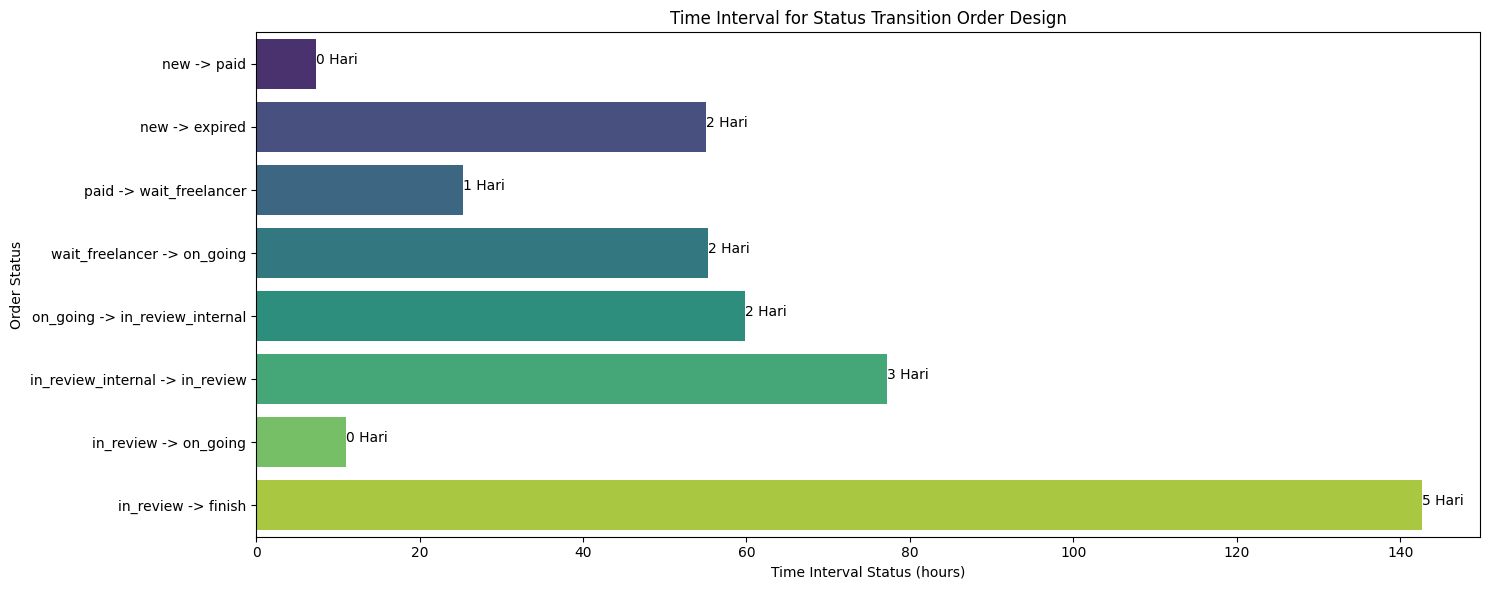

In [27]:
plt.figure(figsize=(15, 6))
sns.barplot(
    y=interval_orderdesign_sorted['old_status'].astype(str) + " -> " + interval_orderdesign_sorted['attributes_status'].astype(str), 
    x="time_interval_status",
    data=interval_orderdesign_sorted,
    palette="viridis"
)

# Menambahkan label batang
for index, value in enumerate(interval_orderdesign_sorted["time_interval_status_days"]):
    plt.text(
        interval_orderdesign_sorted["time_interval_status"][index], 
        index, 
        value, 
        color="black", 
        ha="left"
    )

plt.title("Time Interval for Status Transition Order Design")
plt.xlabel("Time Interval Status (hours)")
plt.ylabel("Order Status")
plt.tight_layout()
plt.show()

**Transisi Tercepat**: Transisi dari status "new" ke "paid" dan dari "in_review" ke "on_going" adalah yang tercepat, hanya membutuhkan waktu 0 hari.  
**Transisi Terlama**: Transisi dari status "in_review" ke "finish" adalah yang terlama, membutuhkan waktu 5 hari.  
**Rata-rata Durasi**: Secara umum, durasi transisi berkisar antara* 0 hingga 5 hari.

## **Order Garden**

In [28]:
interval_ordergarden = proses_subject_type[(proses_subject_type['subject_type'] == 'App\Models\OrderGarden') & (proses_subject_type['attributes_status'].isin(['new', 'paid', 'wait_gardener', 'acc_gardener', 'build_start','in_review', 'finish', 'expired'])) & (proses_subject_type['old_status'].isin(['new', 'paid', 'wait_gardener', 'acc_gardener',  'build_start','in_review', 'finish', 'expired']))]
interval_ordergarden = interval_ordergarden.groupby(['old_status','attributes_status'])['time_interval_status'].mean().sort_values(ascending=True).reset_index()
interval_ordergarden = interval_ordergarden[interval_ordergarden['attributes_status'] != interval_ordergarden['old_status']]
interval_ordergarden = interval_ordergarden[~((interval_ordergarden['old_status'] == 'acc_gardener') & (interval_ordergarden['attributes_status'] == 'in_review'))]
interval_ordergarden['time_interval_status_days'] = interval_ordergarden['time_interval_status'].apply(lambda x: f"{int(x // 24)} Hari")
interval_ordergarden

# Definisikan urutan status yang diinginkan
status_order = ['new', 'paid', 'wait_gardener', 'acc_gardener', 'build_start', 'in_review', 'finish', 'expired']
interval_ordergarden['old_status'] = pd.Categorical(interval_ordergarden['old_status'], categories=status_order, ordered=True)
interval_ordergarden_sorted = interval_ordergarden.sort_values(by='old_status', ascending=True).reset_index(drop=True)

# Menampilkan hasil yang sudah diurutkan
interval_ordergarden_sorted

,old_status,attributes_status,time_interval_status,time_interval_status_days
0,new,paid,7.040225,0 Hari
1,paid,wait_gardener,48.563395,2 Hari
2,wait_gardener,acc_gardener,87.837300,3 Hari
3,acc_gardener,build_start,137.800647,5 Hari
4,build_start,in_review,93.735118,3 Hari
5,in_review,finish,76.338746,3 Hari


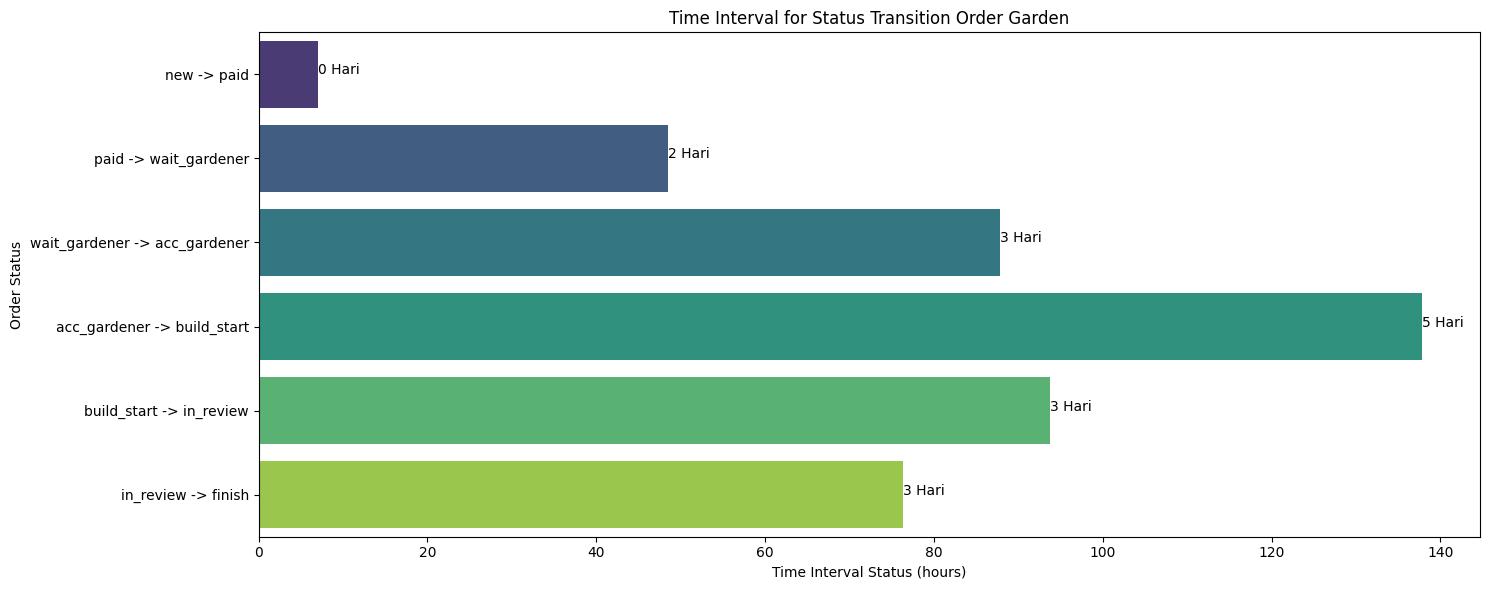

In [29]:
plt.figure(figsize=(15, 6))
sns.barplot(
    y=interval_ordergarden_sorted['old_status'].astype(str) + " -> " + interval_ordergarden_sorted['attributes_status'].astype(str), 
    x="time_interval_status",
    data=interval_ordergarden_sorted,
    palette="viridis"
)

# Menambahkan label batang
for index, value in enumerate(interval_ordergarden_sorted["time_interval_status_days"]):
    plt.text(
        interval_ordergarden_sorted["time_interval_status"][index], 
        index, 
        value, 
        color="black", 
        ha="left"
    )

plt.title("Time Interval for Status Transition Order Garden")
plt.xlabel("Time Interval Status (hours)")
plt.ylabel("Order Status")
plt.tight_layout()
plt.show()

**Tahap Paling Cepat**: Transisi dari status "new" ke "paid" adalah yang paling cepat, hanya membutuhkan waktu 0 hari. Ini mengindikasikan proses pembayaran berjalan dengan sangat efisien.  
**Tahap Paling Lama**: Sebaliknya, tahap konstruksi (dari "acc_gardener" ke "build_start") adalah yang paling lama, membutuhkan waktu hingga 7 hari. Ini menunjukkan bahwa tahap ini mungkin menjadi bottleneck dalam proses keseluruhan.

## **Order Garden Care Detail**

In [30]:
# Filter DataFrame berdasarkan kriteria tertentu
interval_ordercare = proses_subject_type[
    (proses_subject_type['subject_type'] == 'App\Models\OrderGardenCareDetail') &
    (proses_subject_type['attributes_status'].isin(['paid', 'wait_gardener', 'on_going', 'acc_gardener', 'in_review', 'expired'])) &
    (proses_subject_type['old_status'].isin(['new', 'paid', 'wait_gardener', 'on_going', 'acc_gardener', 'in_review', 'expired'])) &
    (proses_subject_type['attributes_status'] != proses_subject_type['old_status'])  # Pastikan status berubah
]

# Tambahkan kolom untuk status perpindahan
interval_ordercare['status_ordergardencaredetail'] = interval_ordercare['old_status'] + '  -->  ' + interval_ordercare['attributes_status']

# Daftar status yang relevan
relevant_status = ['new  -->  paid', 'acc_gardener  -->  in_review', 'paid  -->  acc_gardener', 'wait_gardener  -->  in_review']

# Filter berdasarkan status yang relevan
interval_ordercare = interval_ordercare[interval_ordercare['status_ordergardencaredetail'].isin(relevant_status)]

# Pastikan interval_ordercare tidak kosong setelah penyaringan
if not interval_ordercare.empty:
    # Hitung rata-rata waktu interval status
    result = interval_ordercare.groupby('status_ordergardencaredetail')['time_interval_status'].mean().reset_index()
    result['time_interval_status_days'] = result['time_interval_status'].apply(lambda x: f"{int(x // 24)} Hari")

    # Tentukan urutan status perpindahan yang diinginkan
    status_order = ['new  -->  paid', 'paid  -->  acc_gardener', 'acc_gardener  -->  in_review', 'wait_gardener  -->  in_review']
    result['status_ordergardencaredetail'] = pd.Categorical(result['status_ordergardencaredetail'], categories=status_order, ordered=True)

    # Urutkan hasil berdasarkan urutan status perpindahan
    result = result.sort_values(by='status_ordergardencaredetail').reset_index(drop=True)

# Tampilkan hasil
result

,status_ordergardencaredetail,time_interval_status,time_interval_status_days
0,new --> paid,11.470800,0 Hari
1,paid --> acc_gardener,495.851097,20 Hari
2,acc_gardener --> in_review,93.143749,3 Hari
3,wait_gardener --> in_review,611.794200,25 Hari


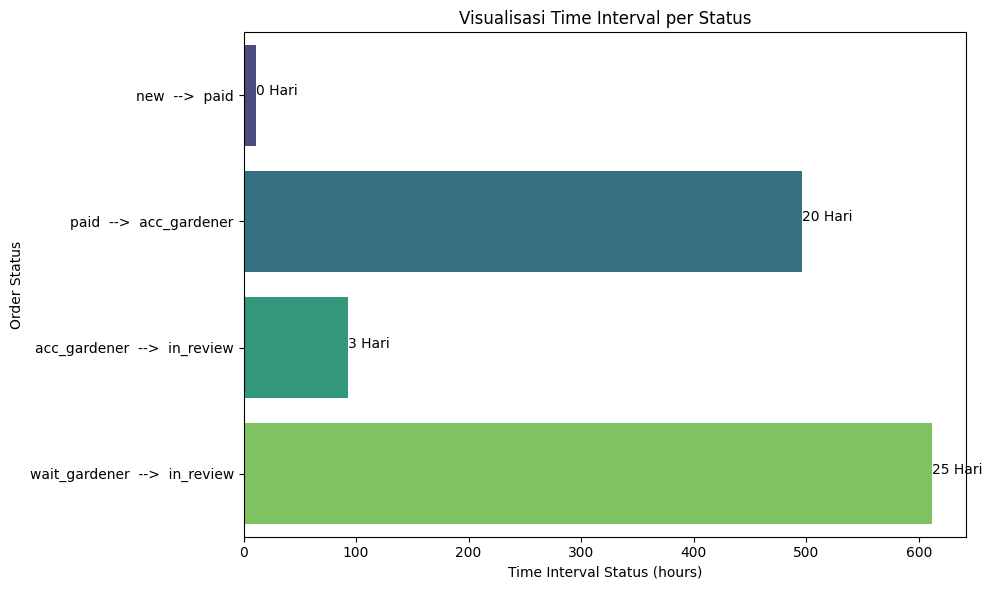

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(
    y="status_ordergardencaredetail",
    x="time_interval_status",
    data=result,
    palette="viridis"
)

# Menambahkan label batang
for index, value in enumerate(result["time_interval_status_days"]):
    plt.text(
        result["time_interval_status"][index], 
        index, 
        value, 
        color="black", 
        ha="left"
    )

plt.title("Visualisasi Time Interval per Status")
plt.xlabel("Time Interval Status (hours)")
plt.ylabel("Order Status")
plt.tight_layout()
plt.show()

Proses dari "new" ke "paid" sangat cepat, menunjukkan sistem pembayaran yang efisien.  
Tahap dari "paid" ke "acc_gardener" memakan waktu paling lama, mengindikasikan potensi bottleneck di sini.  
Tahap peninjauan dari "acc_gardener" ke "in_review" relatif singkat. Namun, perlu diperhatikan bahwa ada jalur alternatif melalui "wait_gardener" yang membutuhkan waktu lebih lama. 